In [108]:
import pydrake
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import cv2
import os
%matplotlib inline

([<matplotlib.axis.XTick at 0x7f389f9f4d00>,
 <a list of 5 Text xticklabel objects>)

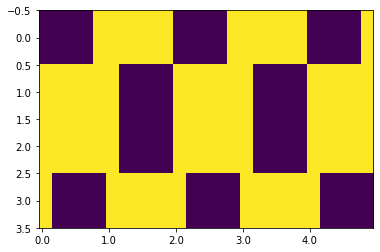

In [109]:
g = 9.81

def rotation_z_mat(psi_k):
    # returns the rotation matrix for a rotation about the z axis
    return np.array([[np.cos(psi_k), -np.sin(psi_k), 0],
                     [np.sin(psi_k), np.cos(psi_k), 0],
                     [0, 0, 1]])

def get_foot_positions(p_k, psi_k, l, v, v_cmd, omega_cmd, h=0.5, t_stance=2, k=0.03):
    """
    Foot step planner
    returns the foot positions for a given step k, defined as a vector from the body center of mass to the foot
    
    inputs:
    
    p_k - body position at step k, wrt world
    
    psi_k - body orientation at step k
    
    l - i_th leg shoulder location wrt body frame, (4,) array
        - convention: [FL, FR, BL, BR]
        
    v - body velocity at step k
    
    v_cmd - commanded body velocity
    
    omega_cmd - commanded body angular velocity
    
    t_stance - stance time
    
    k - velocity gain
    
    h - step height ????
    """
    positions = []
    p_symmetry = 0#t_stance * v / 2 + k * (v - v_cmd) 
    p_centrifugal = 0#0.5 * np.sqrt(h/g) * np.cross(v, omega_cmd)
    for i in range(4):
        # p_shoulder is the i-th shoulder location wrt global frame
        p_shoulder = p_k + rotation_z_mat(psi_k) @ l[i]
        positions.append(p_shoulder + p_symmetry + p_centrifugal)
        
    return positions

def gen_body_trajectory(v, omega, dt, N, z=0.5):
    """
    Generates a body trajectory for a given velocity and angular velocity
    
    input:
    
    v - x, y body velocity
    
    z - body height
    
    omega - body angular velocity, scalar
    
    dt - time step
    
    N - number of steps
    
    returns:
    8D trajectory vector: (x, y, z, x_dot, y_dot, z_dot=0, psi, psi_dot=omega)
    """
    body_trajectory = np.zeros((N, 8))
    rot_mat = rotation_z_mat(omega * dt)
    v = np.append(v, 0)
    for i in range(N):
        if i > 0:
            body_trajectory[i, :3] = rot_mat @ (body_trajectory[i-1, :3] + v * dt)
        
        body_trajectory[i, 6] = i * omega * dt
        body_trajectory[i, 7] = omega
    
    body_trajectory[:, 2] = z
    return body_trajectory



class ContactScheduler:
    """
    Contact Scheduler assigns contact sequence for next N steps
    """
    def __init__(self, period, dt):
        self.period = period
        self.dt = dt
        self.phase = 0
        
    def make_trot_contact_sequence(self, N, t):
        """
        Makes a trot contact sequence for the next N steps, starting at time t
        
        inputs:
        
        N - number of steps
        t - current time
        
        output:
        
        contact_sequence - (N, 4) array, where each row is a contact sequence for a step
        """
        # trot_phase_offsets are the percentage offset where contact should start
        trot_phase_offsets = [0.6, 0, 0, 0.5]
        contact_sequence = np.zeros((N, 4))
        # t_stance is how long the robot spends in stance
        t_stance = 0.6 * self.period
        
        for i in range(N):
            time = t + i * self.dt
            for j in range(4):
                phase = (time + trot_phase_offsets[j] * self.period) % self.period
                if phase < t_stance:
                    contact_sequence[i, j] = 1
        return contact_sequence

p_k = np.array([0, 0, 0])
psi_k = 0
l_i = [np.array([0.5,0.5,0]),
    np.array([0.5,-0.5,0]),
    np.array([-0.5,0.5,0]),
    np.array([-0.5,-0.5,0])]
v = np.array([0.5, 0, 0])
v_cmd = np.array([0.5, 0, 0])
omega_cmd = np.array([0, 0, 1])


body_cmd_vel = np.array([0.5, 0])
omega = np.pi/200
dt = 0.1
N = 50
body_traj = gen_body_trajectory(body_cmd_vel, omega, dt, N)

contact_scheduler = ContactScheduler(2, dt)
contact_sequence = contact_scheduler.make_trot_contact_sequence(N, 0)

t = 0
prev_contacts = np.zeros(4)
foot_positions = np.zeros((N, 4, 3))

for i in range(N):
    body_state = body_traj[i]
    contacts = contact_sequence[i]
    # get the indices where leg went from not in contact to in contact
    new_in_contact = np.where(np.logical_and(prev_contacts == 0, contacts == 1))[0]
    # get the indices where leg went from in contact to not in contact
    new_out_contact = np.where(np.logical_and(prev_contacts == 1, contacts == 0))[0]
    
    new_foot_positions = get_foot_positions(body_state[:3], 
                                        body_state[6], 
                                        l_i, 
                                        body_state[3:6], 
                                        body_state[3:6], 
                                        omega_cmd)
    
    # foot_positions[i] is the prev foot position, unless it just went out of contact
    foot_positions[i] = foot_positions[i-1]
    for j in new_in_contact:
        foot_positions[i, j] = new_foot_positions[j]
    
    prev_contacts = contacts
    
    fig = plt.figure()
    # plot x,y from body_traj
    plt.plot(body_traj[:, 0], body_traj[:, 1], '.')
    plt.axis('equal')
    
    # plot the x,y positions of foots,
    # FL should be red, FR should be green, BL should be blue, BR should be black
    colors = ['r', 'g', 'b', 'k']
    for j in range(4):
        if contacts[j]:
            plt.plot(foot_positions[i, j, 0], foot_positions[i, j, 1], 'o', color=colors[j])
            
    # draw the convex hull of foot positions in contact, if number of contacts > 2
    if np.sum(contacts) > 2:
        hull = ConvexHull(foot_positions[i, contacts == 1, :2])
        for simplex in hull.simplices:
            plt.plot(foot_positions[i, contacts == 1, 0][simplex], foot_positions[i, contacts == 1, 1][simplex], 'k-')
            
    # save figure to image
    fig.savefig('notebook_outputs/frame_{}.png'.format(i))    
    plt.close(fig)
    
os.system("ffmpeg -r {} -i notebook_outputs/frame_%d.png -vcodec mpeg4 -y movie.mp4".format(int(1/dt)))

plt.figure()
plt.imshow(contact_sequence.T, aspect='auto')
# make the x axis time
plt.xticks(np.arange(0, N, 10), np.arange(0, N*dt, 10*dt))